# Model with Linear Regression



Training set:
  Patients: 728 (79.9%)
  Images: 1107 (79.0%)
  Cancer ratio: 0.484

Test set:
  Patients: 183 (20.1%)
  Images: 295 (21.0%)
  Cancer ratio: 0.447
Cross-validation accuracy: 0.677 (+/- 0.076)
Cross-validation accuracy: 0.677 (+/- 0.076)

Final Model Performance:
Accuracy: 0.678
Recall: 0.636
Precision: 0.641
F1-Score: 0.639
AUC-ROC: 0.730

Final Model Performance:
Accuracy: 0.678
Recall: 0.636
Precision: 0.641
F1-Score: 0.639
AUC-ROC: 0.730


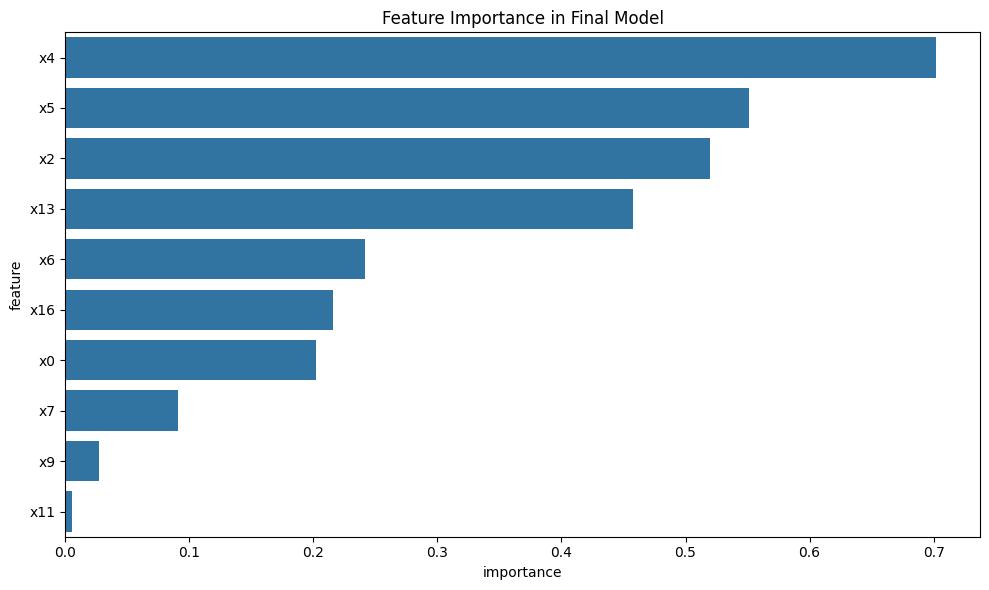

In [23]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, roc_auc_score, 
                           confusion_matrix, roc_curve, precision_recall_curve,
                           precision_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight

# Import additional features
from util.features_all import (measure_pigment_network, measure_blue_veil, 
                             measure_vascular, measure_globules, measure_irregular_pigmentation)
import cv2

# Load and prepare data
data = pd.read_csv('./util/feature_dataset.csv')
data.fillna(0, inplace=True)

# Create features DataFrame properly to avoid SettingWithCopyWarning
features = ['border', 'asymmetry', 'mean_H', 'std_H', 'mean_S', 'std_S', 
           'mean_V', 'std_V', 'White', 'Black', 'Red', 'Light-brown', 
           'Dark-brown', 'Blue-gray']

X = data[features].copy()  # Create a proper copy

# Add feature interaction terms properly using loc
X.loc[:, 'asymmetry_border'] = X['asymmetry'] * X['border']
X.loc[:, 'color_variance'] = X['std_H'] * X['std_S'] * X['std_V']
X.loc[:, 'melanoma_colors'] = X['Black'] + X['Blue-gray'] + X['Red']

# Convert target variable
data['cancer'] = data['cancer'].astype(int)
y = data['cancer']
groups = data['patient_id']

# Handle class imbalance using class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Feature scaling and selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use SelectKBest to choose most important features
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

# Split data with stratification by patient
X_train, X_test, y_train, y_test, groups_train = split_by_patient(data, X_selected, y)

# Create ensemble of models
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

estimators = [
    ('lr', LogisticRegression(class_weight=class_weight_dict, solver='liblinear')),
    ('svc', SVC(probability=True, class_weight=class_weight_dict)),
    ('dt', DecisionTreeClassifier(class_weight=class_weight_dict))
]

# Create stacking classifier
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight=class_weight_dict),
    cv=5
)

# Train model with cross-validation
cv = GroupKFold(n_splits=5)
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', groups=groups_train)
print(f"Cross-validation accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Fit final model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Model Performance:")
print(f"Accuracy: {acc:.3f}")
print(f"Recall: {rec:.3f}")
print(f"Precision: {prec:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc:.3f}")

# Visualize feature importances for the best model
feature_names = selector.get_feature_names_out()
importances = np.abs(clf.named_estimators_['lr'].coef_[0])
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance in Final Model')
plt.tight_layout()
plt.show()

### Patient Distribution



In [13]:
def analyze_patient_groups(data):
    """
    Qucick overvie of data
    Returns a dictionary with patient statistics and grouped data
    """
    #get statistics
    patient_groups = data.groupby('patient_id')
    images_per_patient = patient_groups.size()
    cancer_status_per_patient = patient_groups['cancer'].agg(lambda x: x.unique())
    
    #print stats.
    print(f"Total number of patients: {len(images_per_patient)}")
    print(f"Total number of images: {len(data)}")
    print(f"Average images per patient: {images_per_patient.mean():.2f}")
    print(f"Max images per patient: {images_per_patient.max()}")
    print(f"Min images per patient: {images_per_patient.min()}")
    
    #patients with mixed cancer status
    mixed_status = cancer_status_per_patient[cancer_status_per_patient.apply(len) > 1]
    if len(mixed_status) > 0:
        print(f"\nWarning: {len(mixed_status)} patients have inconsistent cancer status!")
        print("Patients with mixed status:")
        for pat_id in mixed_status.index:
            print(f"Patient {pat_id}: {mixed_status[pat_id]}")
    
    #visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    images_per_patient.hist(bins=20, ax=ax1)
    ax1.set_title('Distribution of Images per Patient')
    ax1.set_xlabel('Number of Images')
    ax1.set_ylabel('Number of Patients')
    
    patient_groups['cancer'].mean().hist(bins=20, ax=ax2)
    ax2.set_title('Distribution of Cancer Ratio per Patient')
    ax2.set_xlabel('Ratio of Cancer Images')
    ax2.set_ylabel('Number of Patients')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'patient_groups': patient_groups,
        'images_per_patient': images_per_patient,
        'cancer_status': cancer_status_per_patient
    }

#analyze groups
patient_analysis = analyze_patient_groups(data)

ValueError: Must produce aggregated value

## Feature Analysis and Visualization

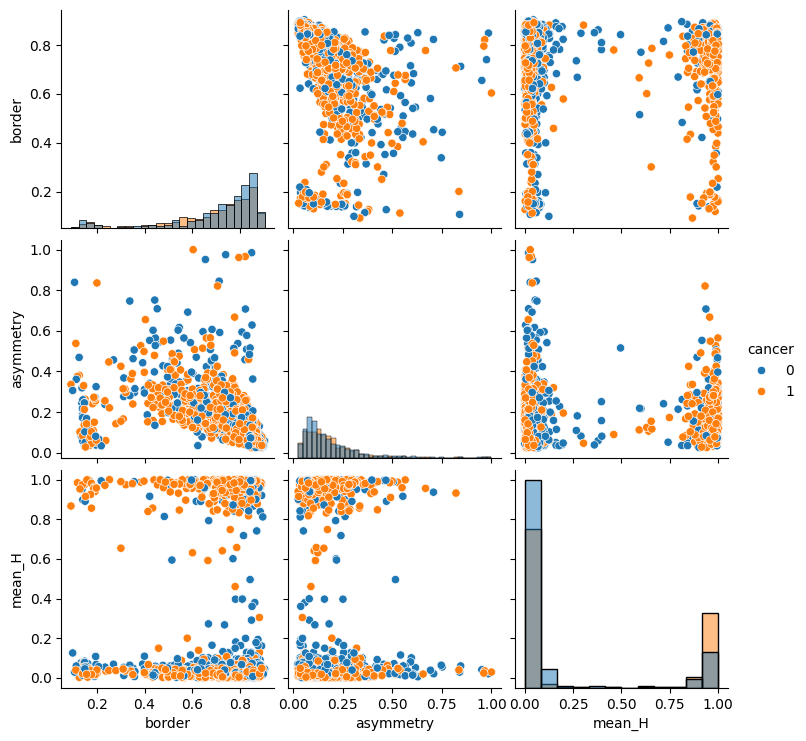

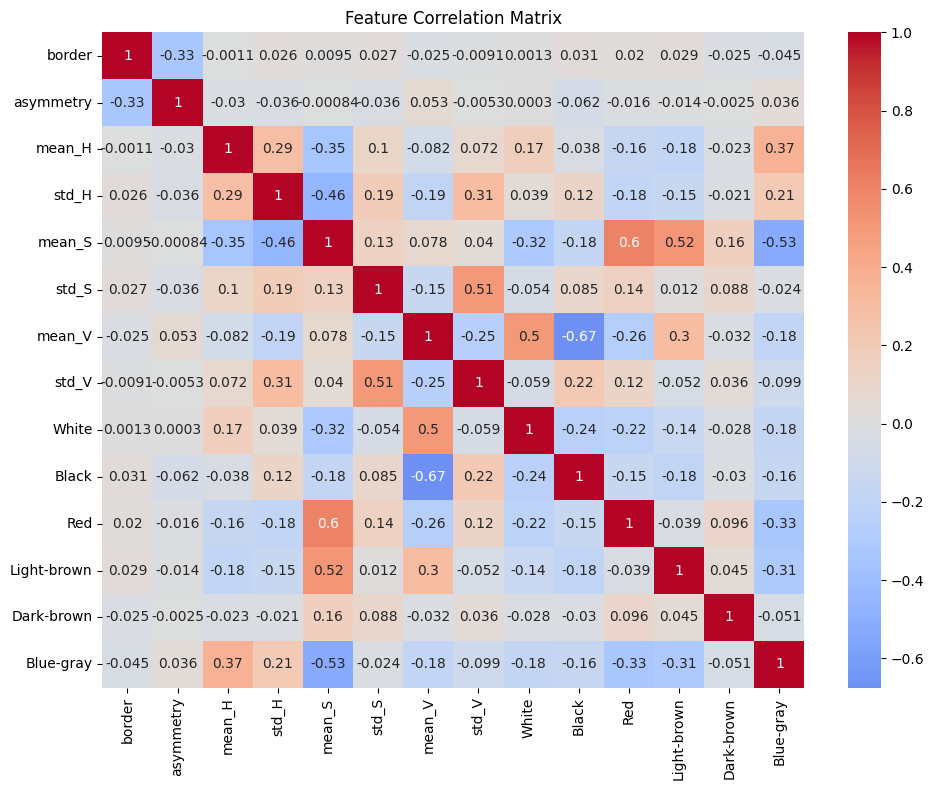

In [14]:
#pairplott
main_features = data[['border', 'asymmetry', 'mean_H', 'cancer']]
sns.pairplot(main_features, hue='cancer', diag_kind='hist')
plt.show()


# correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

###Split

In [15]:
def split_by_patient(data, X, y, test_size=0.2, random_state=42):
    """
    splitting the dataset keeping all the images from paitent in one group.
    Returns train and test indices that respect patient grouping
    """
    unique_patients = data['patient_id'].unique()
    
    # split the set into test and training
    train_patients, test_patients = train_test_split(
        unique_patients, 
        test_size=test_size,
        random_state=random_state,
        stratify=data.groupby('patient_id')['cancer'].mean().round().values
    )
    
    #boolen masks
    train_mask = data['patient_id'].isin(train_patients)
    test_mask = data['patient_id'].isin(test_patients)
    
    # sanity check
    assert not any(data['patient_id'][train_mask].isin(test_patients)), "Data leakage detected!"
    
    #print stats
    print(f"Training set:")
    print(f"  Patients: {len(train_patients)} ({len(train_patients)/len(unique_patients)*100:.1f}%)")
    print(f"  Images: {train_mask.sum()} ({train_mask.sum()/len(data)*100:.1f}%)")
    print(f"  Cancer ratio: {data[train_mask]['cancer'].mean():.3f}")
    print(f"\nTest set:")
    print(f"  Patients: {len(test_patients)} ({len(test_patients)/len(unique_patients)*100:.1f}%)")
    print(f"  Images: {test_mask.sum()} ({test_mask.sum()/len(data)*100:.1f}%)")
    print(f"  Cancer ratio: {data[test_mask]['cancer'].mean():.3f}")
    
    return X[train_mask], X[test_mask], y[train_mask], y[test_mask], groups[train_mask]

#spill
X_train, X_test, y_train, y_test, groups_train = split_by_patient(data, X, y)

Training set:
  Patients: 728 (79.9%)
  Images: 1107 (79.0%)
  Cancer ratio: 0.484

Test set:
  Patients: 183 (20.1%)
  Images: 295 (21.0%)
  Cancer ratio: 0.447


## Model Training and Cross-Validation

C=0.0001, AUC=0.7056 ± 0.0298
C=0.0003, AUC=0.7071 ± 0.0303
C=0.0007, AUC=0.7090 ± 0.0298
C=0.0018, AUC=0.7127 ± 0.0299
C=0.0048, AUC=0.7167 ± 0.0301
C=0.0127, AUC=0.7199 ± 0.0290
C=0.0048, AUC=0.7167 ± 0.0301
C=0.0127, AUC=0.7199 ± 0.0290
C=0.0336, AUC=0.7223 ± 0.0278
C=0.0886, AUC=0.7233 ± 0.0259
C=0.2336, AUC=0.7235 ± 0.0239
C=0.6158, AUC=0.7237 ± 0.0223
C=0.0336, AUC=0.7223 ± 0.0278
C=0.0886, AUC=0.7233 ± 0.0259
C=0.2336, AUC=0.7235 ± 0.0239
C=0.6158, AUC=0.7237 ± 0.0223
C=1.6238, AUC=0.7236 ± 0.0221
C=1.6238, AUC=0.7236 ± 0.0221
C=4.2813, AUC=0.7235 ± 0.0219
C=11.2884, AUC=0.7233 ± 0.0216
C=29.7635, AUC=0.7234 ± 0.0215
C=4.2813, AUC=0.7235 ± 0.0219
C=11.2884, AUC=0.7233 ± 0.0216
C=29.7635, AUC=0.7234 ± 0.0215
C=78.4760, AUC=0.7234 ± 0.0215
C=78.4760, AUC=0.7234 ± 0.0215
C=206.9138, AUC=0.7234 ± 0.0214
C=545.5595, AUC=0.7234 ± 0.0215
C=206.9138, AUC=0.7234 ± 0.0214
C=545.5595, AUC=0.7234 ± 0.0215
C=1438.4499, AUC=0.7234 ± 0.0215
C=3792.6902, AUC=0.7234 ± 0.0215
C=10000.0000, AUC=0.

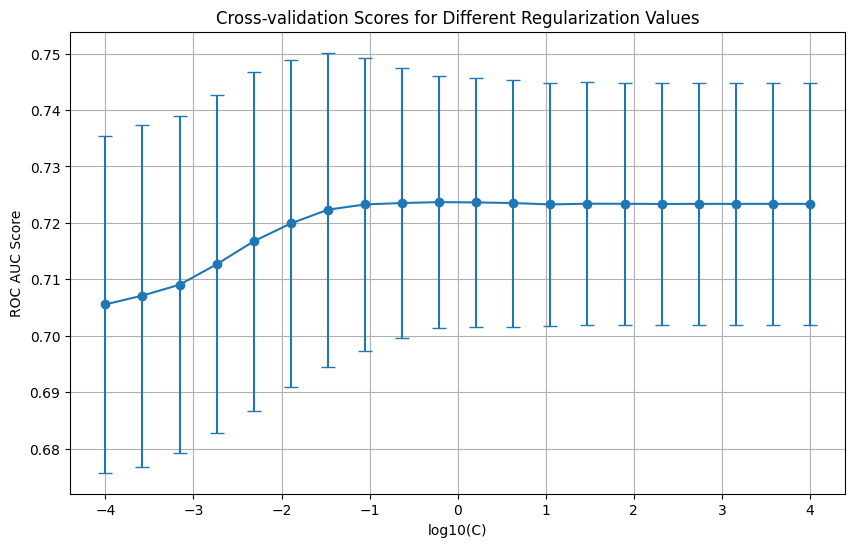

In [16]:
# Create and train the model with cross-validation
cv = GroupKFold(n_splits=5)
regularization_values = np.logspace(-4, 4, 20)
cv_scores = []

for C in regularization_values:
    pipe = make_pipeline(
        StandardScaler(), 
        LogisticRegression(C=C, max_iter=1000, class_weight=class_weight_dict,
                          solver='liblinear')  # Using liblinear solver for better convergence
    )
    scores = cross_val_score(pipe, X_train, y_train, 
                           cv=cv, scoring='roc_auc', 
                           groups=groups_train)
    cv_scores.append({
        'C': C,
        'mean_auc': scores.mean(),
        'std_auc': scores.std()
    })
    print(f"C={C:.4f}, AUC={scores.mean():.4f} ± {scores.std():.4f}")

# Plot regularization parameter tuning results
cv_results = pd.DataFrame(cv_scores)
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=np.log10(cv_results['C']),
    y=cv_results['mean_auc'],
    yerr=cv_results['std_auc'],
    fmt='-o',
    capsize=5
)
plt.xlabel('log10(C)')
plt.ylabel('ROC AUC Score')
plt.title('Cross-validation Scores for Different Regularization Values')
plt.grid(True)
plt.show()

## Final Model Training and Evaluation

Final Evaluation on Test Set:
Accuracy: 0.6712
Recall: 0.6136
AUC: 0.7328
Confusion Matrix:
[[117  46]
 [ 51  81]]


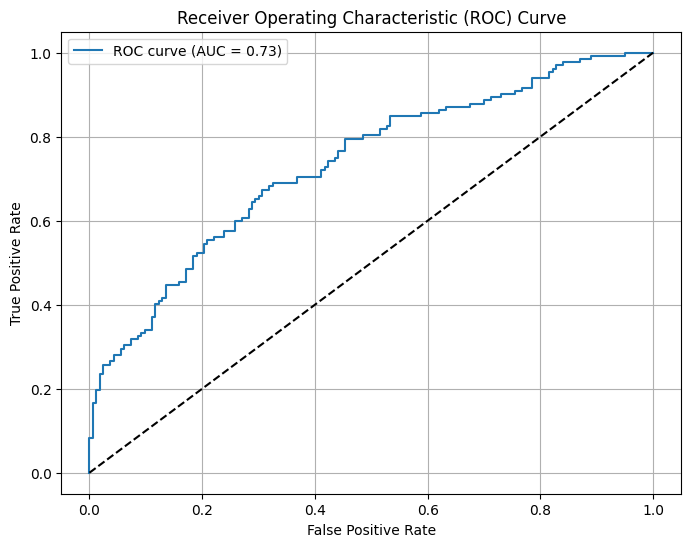

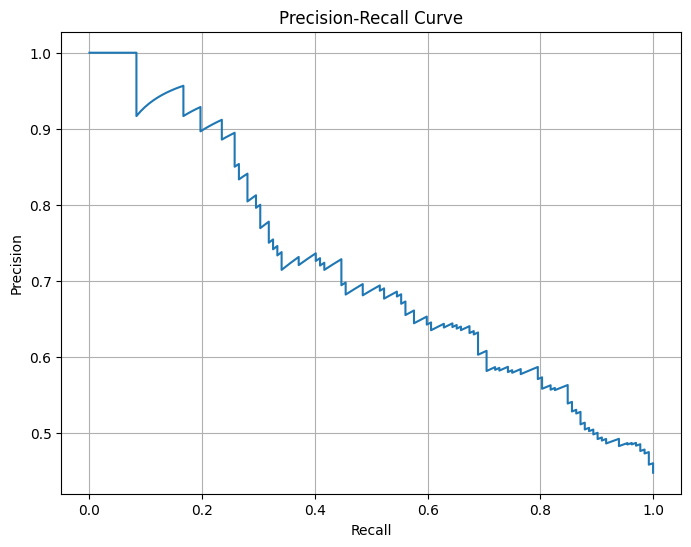

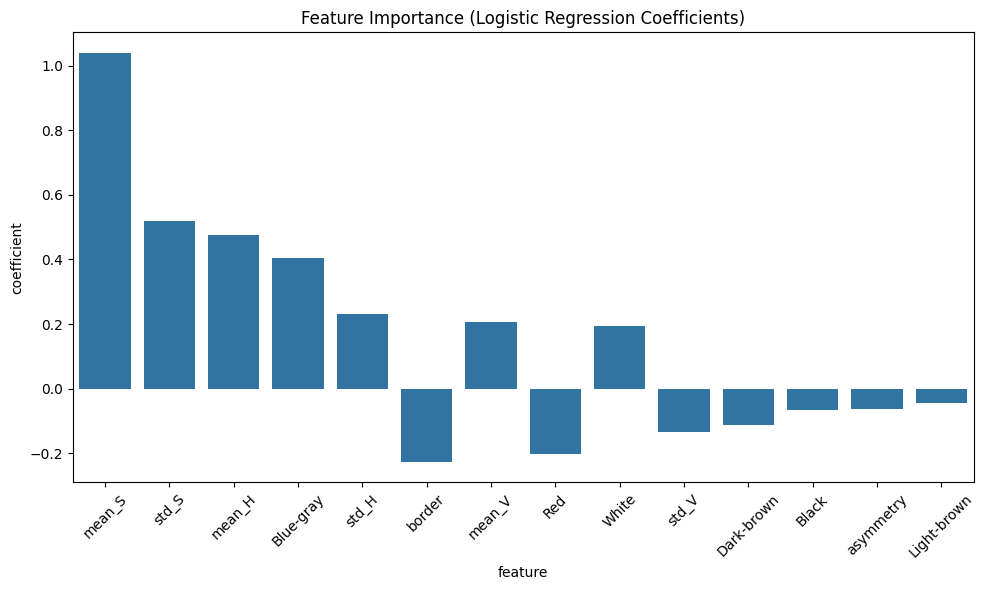

In [17]:
# Train final model with best C value
best_C = cv_results.loc[cv_results['mean_auc'].idxmax(), 'C']
final_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=best_C, max_iter=1000, class_weight=class_weight_dict,
                      solver='liblinear')
)
final_pipe.fit(X_train, y_train)

# Make predictions
y_pred = final_pipe.predict(X_test)
y_prob = final_pipe.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("Final Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Feature importance analysis
scaler = final_pipe.named_steps['standardscaler']
lr_model = final_pipe.named_steps['logisticregression']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_importance': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='feature', y='coefficient')
plt.xticks(rotation=45)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    "patient_id": data.loc[y_test.index, 'patient_id'].values,
    "true_label": y_test.values,
    "cancer_probability": y_prob
})
results_df.to_csv("result/linear_predictions.csv", index=False)

### 3D Feature Space Visualization
Visualizing the relationships between different feature combinations in 3D space

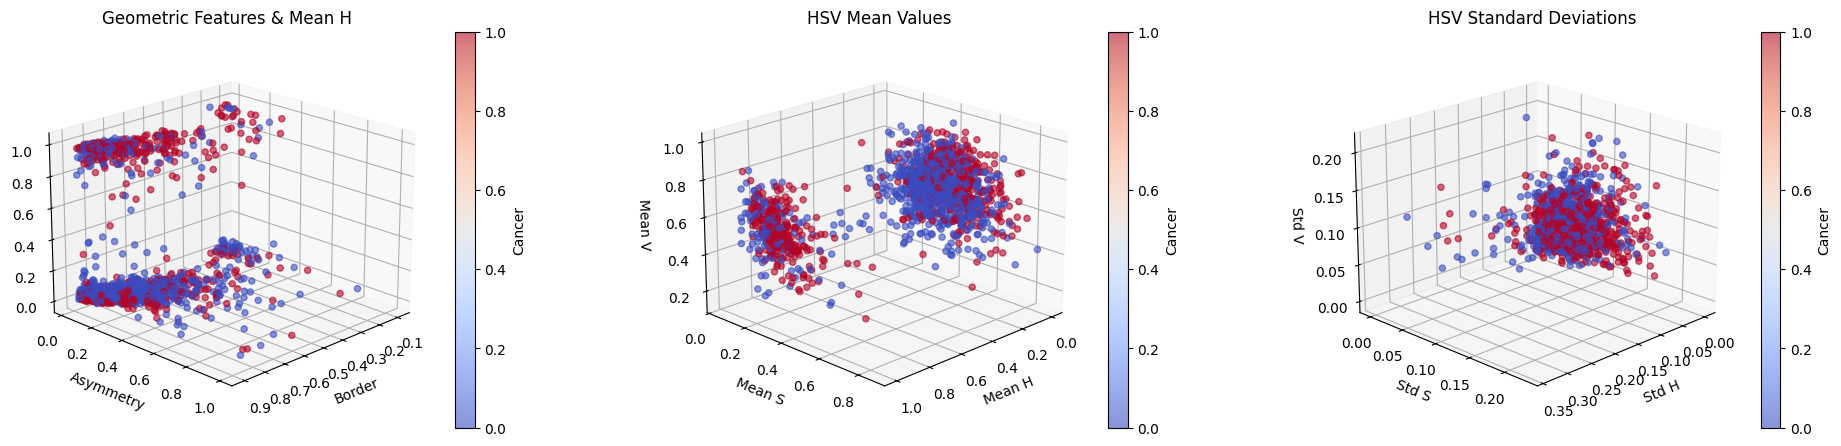

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plots with different feature combinations
fig = plt.figure(figsize=(20, 5))

# Plot 1: Geometric features with mean HSV
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(
    data['border'],
    data['asymmetry'],
    data['mean_H'],
    c=data['cancer'],
    cmap='coolwarm',
    alpha=0.6
)
ax1.set_xlabel('Border')
ax1.set_ylabel('Asymmetry')
ax1.set_zlabel('Mean H')
ax1.set_title('Geometric Features & Mean H')
plt.colorbar(scatter1, ax=ax1, label='Cancer')

# Plot 2: HSV Means
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(
    data['mean_H'],
    data['mean_S'],
    data['mean_V'],
    c=data['cancer'],
    cmap='coolwarm',
    alpha=0.6
)
ax2.set_xlabel('Mean H')
ax2.set_ylabel('Mean S')
ax2.set_zlabel('Mean V')
ax2.set_title('HSV Mean Values')
plt.colorbar(scatter2, ax=ax2, label='Cancer')

# Plot 3: HSV Standard Deviations
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(
    data['std_H'],
    data['std_S'],
    data['std_V'],
    c=data['cancer'],
    cmap='coolwarm',
    alpha=0.6
)
ax3.set_xlabel('Std H')
ax3.set_ylabel('Std S')
ax3.set_zlabel('Std V')
ax3.set_title('HSV Standard Deviations')
plt.colorbar(scatter3, ax=ax3, label='Cancer')

# Add rotation for better visualization
for ax in [ax1, ax2, ax3]:
    ax.view_init(elev=20, azim=45)

plt.tight_layout(pad=3.0)
plt.show()

### Confusion Matrix Visualization

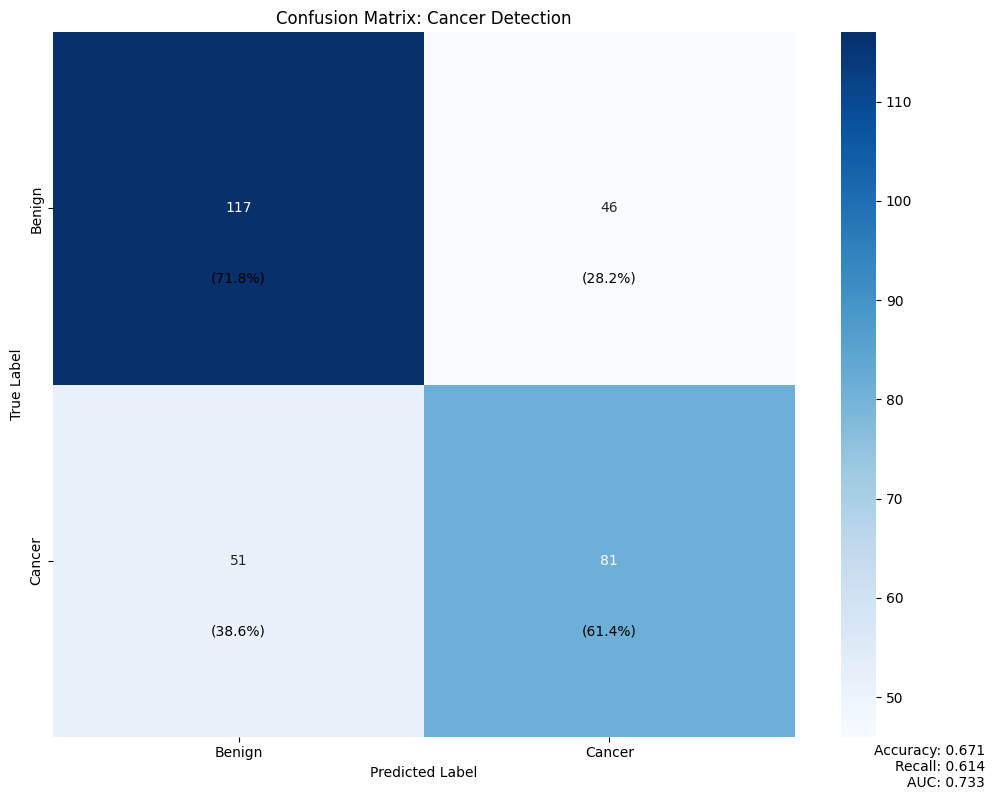


Detailed Metrics:
True Negatives (Correctly identified benign): 117
False Positives (Incorrectly identified as cancer): 46
False Negatives (Missed cancer cases): 51
True Positives (Correctly identified cancer): 81

Additional Metrics:
Specificity (True Negative Rate): 0.718
Precision (Positive Predictive Value): 0.638
Negative Predictive Value: 0.696


In [20]:
# Create a more detailed confusion matrix visualization
plt.figure(figsize=(10, 8))
labels = ['Benign', 'Cancer']

# Create confusion matrix heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)

# Calculate percentages for annotation
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Add percentage annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = plt.text(j + 0.5, i + 0.7, f'({cm_percentages[i, j]:.1f}%)',
                       ha='center', va='center')

plt.title('Confusion Matrix: Cancer Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add performance metrics as text
plt.figtext(0.99, 0.01, f'Accuracy: {acc:.3f}\nRecall: {rec:.3f}\nAUC: {auc:.3f}',
           fontsize=10, ha='right')

plt.tight_layout()
plt.show()

# Print detailed metrics
print('\nDetailed Metrics:')
print(f'True Negatives (Correctly identified benign): {cm[0,0]}')
print(f'False Positives (Incorrectly identified as cancer): {cm[0,1]}')
print(f'False Negatives (Missed cancer cases): {cm[1,0]}')
print(f'True Positives (Correctly identified cancer): {cm[1,1]}')

# Calculate and print additional metrics
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
precision = cm[1,1] / (cm[1,1] + cm[0,1])
npv = cm[0,0] / (cm[0,0] + cm[1,0])

print('\nAdditional Metrics:')
print(f'Specificity (True Negative Rate): {specificity:.3f}')
print(f'Precision (Positive Predictive Value): {precision:.3f}')
print(f'Negative Predictive Value: {npv:.3f}')